In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [2]:
print(sklearn.__version__)

0.24.1


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
data = pd.read_csv('stoch_corr_tanh_1000_v2.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1003:1004]

In [6]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [7]:
params_reshape

array([[[0.14900685]],

       [[0.12133695]],

       [[0.13299469]],

       ...,

       [[0.14946312]],

       [[0.14288562]],

       [[0.12802695]]])

In [8]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.LSTM(units=16, return_sequences=True, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.LSTM(units=16,return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16,return_sequences=True))
model.add(layer=tf.keras.layers.LSTM(units=16))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             65024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 71,377
Trainable params: 71,377
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.mae,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=100, validation_split=0.2, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/100
2500/2500 [==============================] - 41s 14ms/step - loss: 0.0533 - val_loss: 0.0076
Epoch 2/100
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 3/100
2500/2500 [==============================] - 32s 13ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 4/100
2500/2500 [==============================] - 27s 11ms/step - loss: 0.0075 - val_loss: 0.0076


In [15]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.005:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0]) 
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 4/500 [00:00<00:33, 14.99it/s][[0.13126305]] [[0.12221993]]
[[0.13372398]] [[0.14510819]]
[[0.13396946]] [[0.13982229]]
[[0.13396996]] [[0.14826645]]
  2%|▏         | 9/500 [00:00<00:28, 17.18it/s][[0.13372398]] [[0.1365283]]
[[0.13267479]] [[0.12846766]]
[[0.13397031]] [[0.12422045]]
[[0.13397031]] [[0.12454337]]
[[0.13372398]] [[0.12045831]]
  2%|▏         | 12/500 [00:00<00:27, 18.04it/s][[0.13372398]] [[0.14323421]]
[[0.1339703]] [[0.12331626]]
[[0.13396901]] [[0.12691803]]
[[0.13462563]] [[0.13831187]]
  3%|▎         | 17/500 [00:00<00:24, 19.82it/s] [[0.14325962]]
[[0.13396946]] [[0.12930317]]
[[0.13372339]] [[0.12248501]]
[[0.13372398]] [[0.14838466]]
[[0.13372398]] [[0.1272357]]
  5%|▍         | 23/500 [00:01<00:22, 21.24it/s][[0.13372398]] [[0.12725927]]
[[0.13396574]] [[0.13673859]]
[[0.13396994]] [[0.14675293]]
[[0.13372398]] [[0.1488157]]
[[0.13396985]] [[0.12136764]]
  5%|▌         | 26/500 [00:01<00:21, 22.20it/s][[0.13372398]] [[0.13867564]]
[[0.13372398

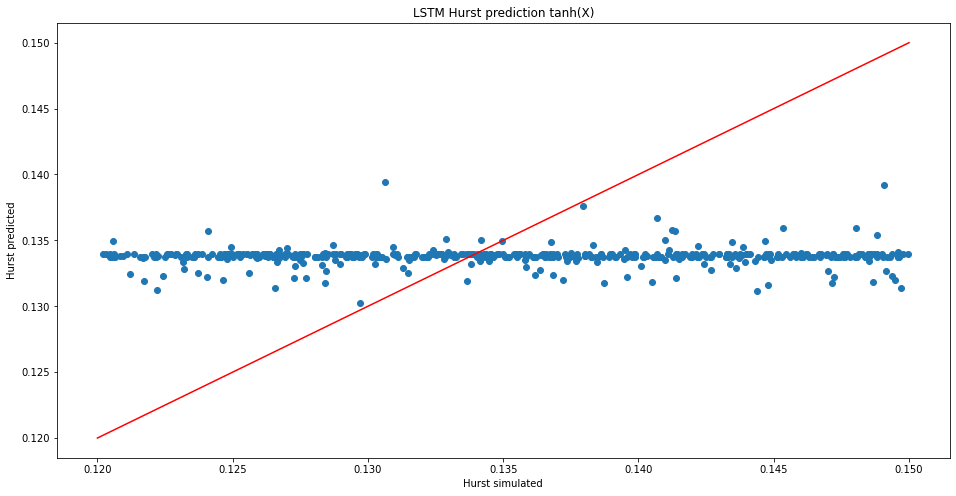

In [16]:
plt.figure(figsize=(16,8))
plt.plot([0.12,0.15], [0.12,0.15], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('Hurst simulated')
plt.ylabel('Hurst predicted')
plt.title('LSTM Hurst prediction tanh(X)')
plt.show()

In [12]:
simulated = []
predicted = []

append_index = 0
start = 10000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.005:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0]) 
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 3/500 [00:00<00:22, 21.74it/s][[0.13397029]] [[0.13553575]]
[[0.13386898]] [[0.12751306]]
[[0.13372376]] [[0.12908739]]
[[0.13397031]] [[0.12133486]]
[[0.13372398]] [[0.14535367]]
  2%|▏         | 9/500 [00:00<00:21, 22.54it/s] [[0.14024045]]
[[0.13397017]] [[0.13733912]]
[[0.13372398]] [[0.14877548]]
[[0.13397031]] [[0.12825748]]
[[0.13166908]] [[0.13105769]]
  3%|▎         | 15/500 [00:00<00:20, 23.40it/s] [[0.12092103]]
[[0.13396933]] [[0.12547881]]
[[0.13327286]] [[0.14113596]]
[[0.13372398]] [[0.1280845]]
[[0.13372398]] [[0.13258262]]
  4%|▍         | 21/500 [00:00<00:19, 24.17it/s] [[0.14881085]]
[[0.13372398]] [[0.13383629]]
[[0.13397031]] [[0.12818526]]
[[0.13397029]] [[0.13434542]]
[[0.13396938]] [[0.13957697]]
[[0.13397028]] [[0.12788645]]
  5%|▌         | 27/500 [00:01<00:19, 24.45it/s][[0.13372398]] [[0.14939712]]
[[0.13380554]] [[0.13783657]]
[[0.13372398]] [[0.14389149]]
[[0.13417083]] [[0.13687449]]
[[0.13372398]] [[0.1294396]]
[[0.13395028]] [[0.1280673

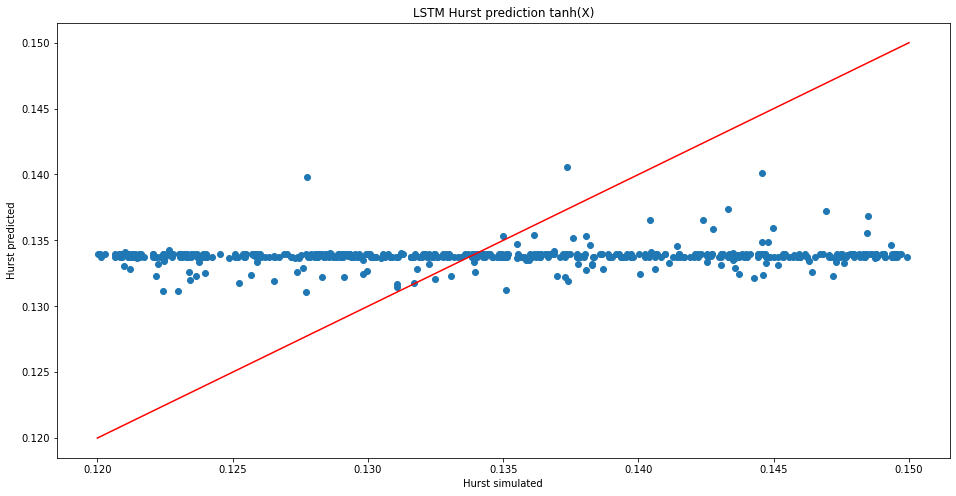

In [13]:
plt.figure(figsize=(16,8))
plt.plot([0.12,0.15], [0.12,0.15], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('Hurst simulated')
plt.ylabel('Hurst predicted')
plt.title('LSTM Hurst prediction tanh(X)')
plt.show()

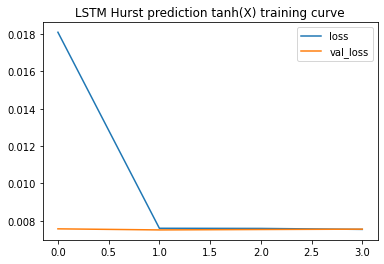

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Hurst prediction tanh(X) training curve')
plt.legend(['loss', 'val_loss'])
plt.show()